# Praca domowa 6
#### Ilona Bednarz

## Odtworzenie modeli z PD1 i PD5

### Zmienna objaśniana:
S1 - Are you married?

### Wybrane zmienne objaśniające:

#### numeryczne:

* Q16: How many of your relatives do you see in person at least once a month?  - numeryczna

* pphhsize: Household Size

#### binarne:

* hcm2017q24_church: met in or through church or religious organization

* w6_otherdate_all: In past yr have you met anyone for dating romance or sex (not incl current partner)

### Zbudowane modele:
* RandomForest
* SVM

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from IPython.display import display
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from pygam import LinearGAM

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

df = pd.read_stata('dane/HCMST_2017.dta')

# wybor zmiennych
X = df[['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']].copy()
y = df['S1'].copy()

# przygotowanie danych
X['w6_otherdate_all'] = X['w6_otherdate_all'].replace('Refused', np.nan)
y = y[np.sum(X.isna(), axis=1) == 0]
X = X.dropna(axis=0).reset_index(drop=True)
bin_columns = ["hcm2017q24_church", "w6_otherdate_all"]
dummies = pd.get_dummies(X[bin_columns]).iloc[:, [1, 4]]
dummies.columns = bin_columns
X[bin_columns] = dummies
y = pd.get_dummies(y).iloc[:, 0].reset_index(drop=True) # 1 == married

# dopasowanie modelu rf
rf = RandomForestClassifier(n_jobs=-1, n_estimators=600, random_state=123, max_depth=4)
rf.fit(X, y)

# dopasowanie modelu svm
svm_mod = svm.SVC(kernel='rbf', gamma=0.001, C=2000, probability = True)
svm_mod.fit(X, y)

SVC(C=2000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Porównanie jakości predykcji obu modeli

In [2]:
print('Random forest score AUC: ', np.mean(cross_val_score(rf, X, y, cv=10, scoring='roc_auc', n_jobs=-1)))
print('SVM score AUC: ', np.mean(cross_val_score(svm_mod, X, y, cv=10, scoring='roc_auc', n_jobs=-1)))

Random forest score AUC:  0.7002180146564475
SVM score AUC:  0.6808955055802071


Modele mają zbliżone AUC pomimo różnej struktury.

## Reszty modeli dla danych uczących

In [3]:
def residuals(model, X, y):
    y_pred = model.predict_proba(X)[:,1]
    resid = (y.astype(np.float64) - y_pred.astype(np.float64)).tolist() 
    return resid, y_pred

rf_residuals, rf_y_pred = residuals(rf, X, y)
svm_residuals, svm_y_pred = residuals(svm_mod, X, y)

#### Rozkład reszt

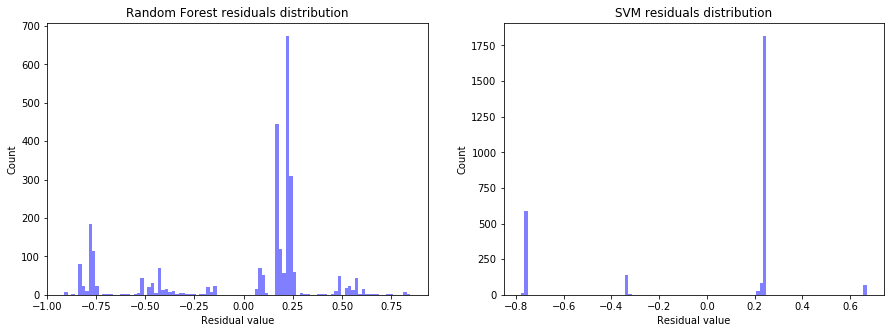

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(rf_residuals, 100, facecolor='blue', alpha=0.5)
plt.title('Random Forest residuals distribution')
plt.xlabel('Residual value')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(svm_residuals, 100, facecolor='blue', alpha=0.5)
plt.title('SVM residuals distribution')
plt.xlabel('Residual value')
plt.ylabel('Count')

plt.show()

Największe skoki histogramu występują w tych samych punktach dla obu modeli. Lecz model lasu losowego ma dużo więcej unikalnych wartości rezyduów.

### Zależność reszt od y_hat

In [7]:
def trend_line(residuals, fitted):
    gam = LinearGAM().fit(residuals, fitted)
    XX = gam.generate_X_grid(term=0, n = 1000)
    smooth_index = XX > 0
    x_smooth = XX[smooth_index]
    y_smooth = gam.partial_dependence(term=0, X=XX)[smooth_index.flatten()]
    return x_smooth, y_smooth

In [8]:
rf_x_smooth, rf_y_smooth = trend_line(rf_residuals, rf_y_pred)
svm_x_smooth, svm_y_smooth = trend_line(svm_residuals, svm_y_pred)

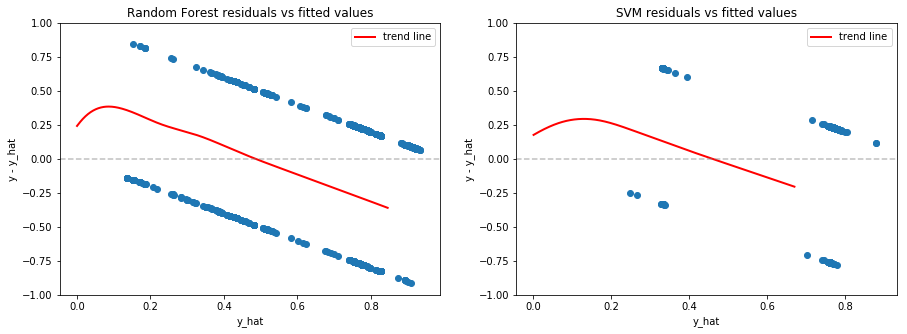

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(rf_y_pred, rf_residuals)
plt.plot(rf_x_smooth, rf_y_smooth, 'red', linewidth=2, label='trend line')
plt.axhline(0, color='grey', alpha=0.5, linestyle="--")
plt.title('Random Forest residuals vs fitted values')
plt.xlabel('y_hat')
plt.ylabel('y - y_hat')
plt.ylim(-1,1)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(svm_y_pred, svm_residuals)
plt.plot(svm_x_smooth, svm_y_smooth, 'red', linewidth=2, label='trend line')
plt.axhline(0, color='grey', alpha=0.5, linestyle="--")
plt.title('SVM residuals vs fitted values')
plt.xlabel('y_hat')
plt.ylabel('y - y_hat')
plt.ylim(-1,1)
plt.legend()

plt.show()

#### Interpretacja

Ułożenie reszt w dwie równoległe, pochylone linie, wynika ze specyfiki problemu klasyfikacji do dwóch klas: y przyjmuje wartości ze zbioru {0,1}, natomiast y_hat z przedziału (0,1), co determinuje właśne takie ułożenie reszt.

Dla obu modeli wykresy reszt są bardzo podobne. Różnica polega na tym, że dla Random Forest przyjmują one więcej różnych wartości, co też widzieliśmy na wcześniejszych histogramach. Czerwona linia trendu przecina poziomą prostą {y=0} w okolicach x=0.5, co może być sygnałem, że modele są dobrze dopasowane (przynajmniej do zbioru treningowego).

### Zależność reszt od zmiennej zależnej

In [10]:
rf_x_smooth, rf_y_smooth = trend_line(X['Q16'], rf_residuals)
svm_x_smooth, svm_y_smooth = trend_line(X['Q16'], svm_residuals)

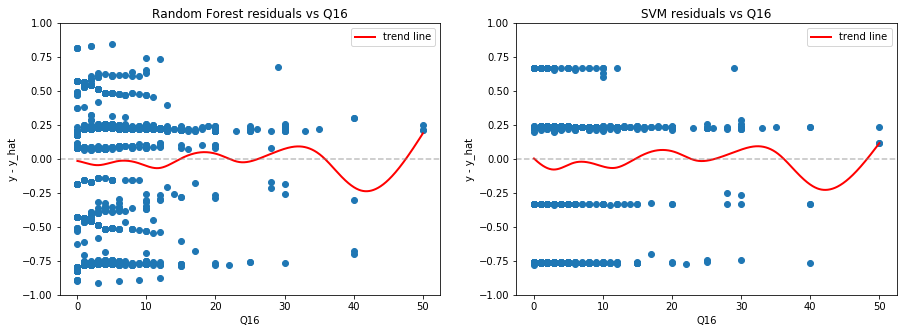

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(X['Q16'], rf_residuals)
plt.plot(rf_x_smooth, rf_y_smooth, 'red', linewidth=2, label='trend line')
plt.axhline(0, color='grey', alpha=0.5, linestyle="--")
plt.title('Random Forest residuals vs Q16')
plt.xlabel('Q16')
plt.ylabel('y - y_hat')
plt.ylim(-1,1)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X['Q16'], svm_residuals)
plt.plot(svm_x_smooth, svm_y_smooth, 'red', linewidth=2, label='trend line')
plt.axhline(0, color='grey', alpha=0.5, linestyle="--")
plt.title('SVM residuals vs Q16')
plt.xlabel('Q16')
plt.ylabel('y - y_hat')
plt.ylim(-1,1)
plt.legend()

plt.show()

### Interpretacja
Powyżej widzimy wykresy reszt modeli w zależności od wartości zmiennej zależnej *Q16*, która oznacza liczbę członków rodziny, z którymi jest utrzymywany regularny kontakt. Linia trendu oscyluje na poziomie y=0, co jest dobrym znakiem. Oznacza to, że wartość zmiennej zależnej *Q16* nie ma wpływu na to, w którą stronę myli się model, tzn. czy dostajemy false positive czy false negative. Jest to sytuacja pożądana.



## Odległości Cooka

In [34]:
def cook_distance(X, y, i, model, preds, mserr):
    X_i = X.copy().drop(X.index[[i]]).reset_index(drop=True)
    y_i = y.copy().drop(y.index[[i]]).reset_index(drop=True)
    model.fit(X_i, y_i)
    preds_i = model.predict_proba(X)[:,1]
    cook = (np.sum(((preds-preds_i)**2)))/mserr
    return cook

rf = RandomForestClassifier(n_jobs=-1, n_estimators=600, random_state=123, max_depth=4)
svm_mod = svm.SVC(kernel='rbf', gamma=0.001, C=2000, probability = True, max_iter=100)

rf_mserr = np.sum((rf_y_pred-y)**2)/(X.shape[0]-4)
svm_mserr = np.sum((svm_y_pred-y)**2)/(X.shape[0]-4)

rf_cooks = []
svm_cooks = []
for i in range(X.shape[0]):
    rf_cooks.append(cook_distance(X, y, i, rf, rf_y_pred, rf_mserr))
    svm_cooks.append(cook_distance(X, y, i, svm_mod, svm_y_pred, svm_mserr))

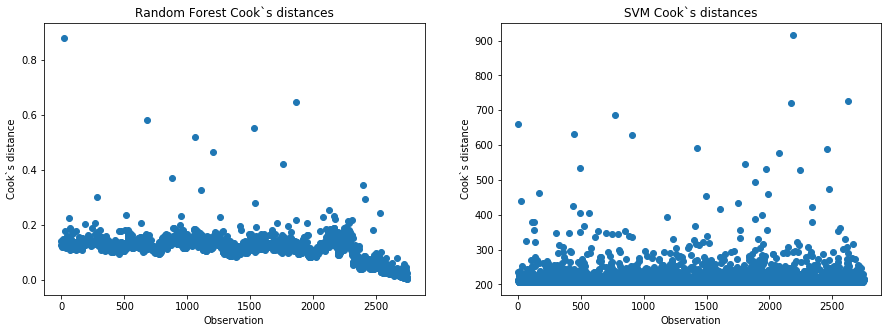

In [35]:
plt.figure(figsize=(15,5))

ind = list(range(X.shape[0]))

plt.subplot(1,2,1)
plt.scatter(ind, rf_cooks)
plt.title('Random Forest Cook`s distances')
plt.xlabel('Observation')
plt.ylabel('Cook`s distance')

plt.subplot(1,2,2)
plt.scatter(ind, svm_cooks)
plt.title('SVM Cook`s distances')
plt.xlabel('Observation')
plt.ylabel('Cook`s distance')

plt.show()

### Interpretacja
Można zauważyć kilka obserwacji wpływowych dla modelu random forest oraz kilkanaście dla modelu SVM.